In [1]:
from qiskit.visualization.timeline import draw
from qiskit import QuantumCircuit, assemble, Aer, ClassicalRegister, QuantumRegister
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit import IBMQ, transpile

In [2]:

def get_backend(is_simulator=True):
    IBMQ.load_account()
    provider = IBMQ.providers()[0]
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().simulator == is_simulator and x.status().operational))
    
    return backend 

In [79]:
def create_controlled_pauli(pauli_gate_init, leftmost_index_is_zeroth=True):
    if leftmost_index_is_zeroth:
        pauli_gate = pauli_gate_init[::-1]
    else:
        pauli_gate = pauli_gate_init
    pauli_num = len(pauli_gate)
    pauli_input = range(0, pauli_num)
    pauli_circ = QuantumCircuit(pauli_num, name=pauli_gate)
    pauli_circ.pauli(pauli_gate,pauli_input )
    return pauli_circ.control(1, f"controlled {pauli_gate}")


def create_pauli_measurement(pauli_gate, extra_qubits=0, extra_cbits = 0):
    controlled_pauli = create_controlled_pauli(pauli_gate) 
    pauli_num = len(pauli_gate)
    pauli_meas = QuantumCircuit(1 + pauli_num + extra_qubits , 1 + extra_cbits)
    pauli_meas.h(0) # |+>
    pauli_meas.compose(controlled_pauli, range(0, pauli_num + 1), inplace=True,)
    pauli_meas.barrier()
    pauli_meas.h(0) 
    pauli_meas.measure(0,0)
    pauli_meas.barrier()
    return pauli_meas

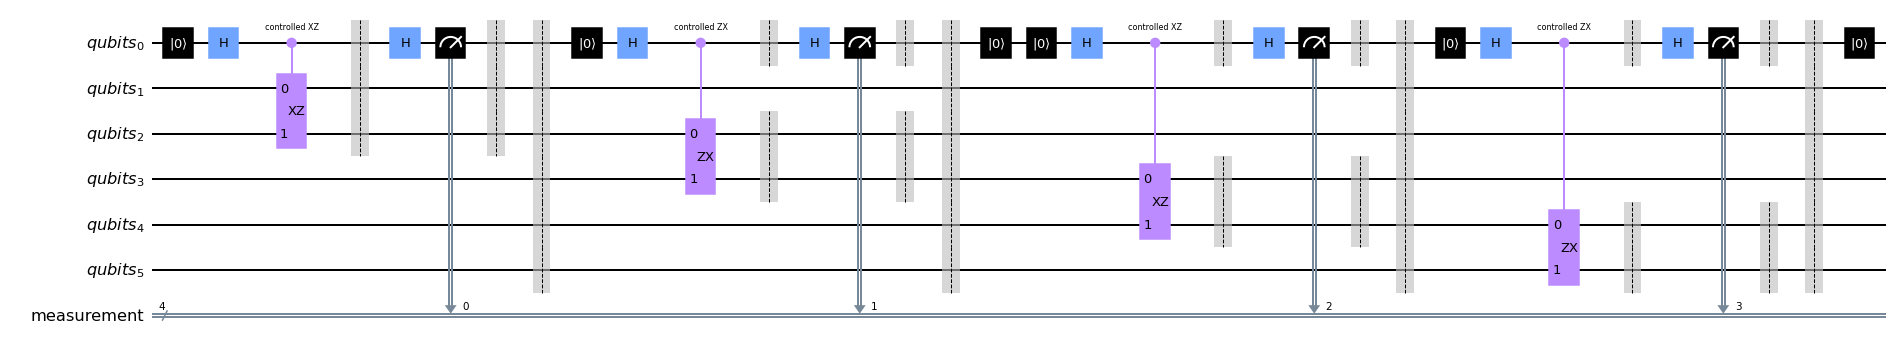

In [80]:
def generate_arc_rep_circ(no_link_bits, start_z=True, init_codeword=None):
    if no_link_bits % 2 == 0:
        print("sadness, must have odd number of bits")
        return 
    qubits = QuantumRegister(no_link_bits + 1,name="qubits")
    meas_bits = ClassicalRegister((no_link_bits  - 1), name="measurement")
    base_circ = QuantumCircuit(qubits, meas_bits)
    meas_count = 0
    for i in range(1, no_link_bits - 1, 2):
        zx_gate = create_pauli_measurement("ZX")
        xz_gate = create_pauli_measurement("XZ")
        if start_z:
            base_circ.reset([0])
            base_circ.compose(zx_gate, qubits=[0, i, i+1], clbits=[meas_count],inplace=True )
            base_circ.barrier()
            base_circ.reset([0])
            base_circ.compose(xz_gate, qubits=[0, i+1, i+2], clbits=[meas_count + 1],inplace=True )
            base_circ.barrier()
            base_circ.reset([0])
        else:
            base_circ.reset([0])
            base_circ.compose(xz_gate, qubits=[0, i, i+1], clbits=[meas_count],inplace=True )
            base_circ.barrier()
            base_circ.reset([0])
            base_circ.compose(zx_gate, qubits=[0, i+1, i+2], clbits=[meas_count + 1],inplace=True )
            base_circ.barrier()
            base_circ.reset([0])
        meas_count += 2
    return base_circ
    
acirc = generate_arc_rep_circ(5)
acirc.draw(output="mpl", fold=100)

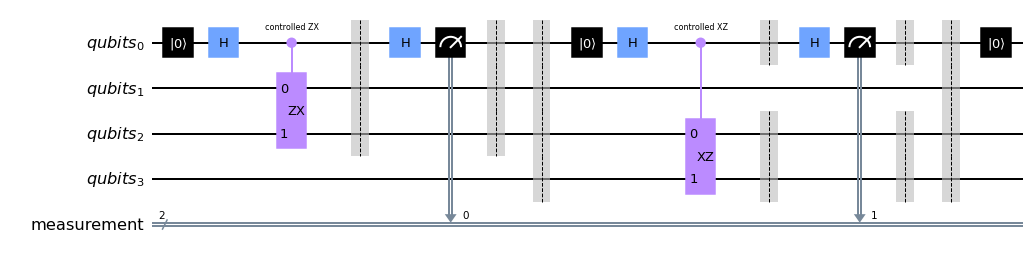

In [84]:
acirc = generate_arc_rep_circ(3,start_z=False)
acirc.draw(output="mpl", fold=100)




In [85]:
simulator = Aer.get_backend('aer_simulator')
probcirccomp = transpile(acirc, simulator)
job = simulator.run(probcirccomp)
job.result().get_counts()

{'01': 272, '10': 233, '11': 266, '00': 253}

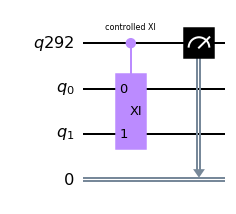

In [86]:
circ = create_controlled_pauli("IX")

output = ClassicalRegister(1)
circ.add_bits(output)
circ.measure(0,0)

circ.draw(output="mpl")
# job = simulator.run(circomp)


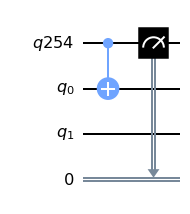

In [78]:
circomp = transpile(circ, simulator)

circomp.draw(output="mpl")